# Mapping SAT Performance and Equity in Texas Independent School Districts
**Author:** YI LUO  
**Date:** 2025-04-23  

This portfolio presents a comprehensive analysis of 2023 SAT participation and performance across Texas Independent School Districts, using public data from the Texas Education Agency (https://tea.texas.gov/).  

**Data Ingestion & Cleaning**  
- Loaded the SAT dataset, handled masked values (e.g. “<25”) and converted all score and rate columns to numeric.  
- Filtered to the “All Students” cohort to build a clean, district-level metrics table (ERW, Math, Total SAT, participation rate, and college-readiness rate).  

**Descriptive & Geospatial Analysis**  
- Computed statewide averages and distribution summaries to benchmark district performance.  
- Joined SAT metrics to ISD boundary shapefiles and produced choropleth maps of:  
  - Average Total SAT score  
  - SAT participation rate  
  - Equity gaps (difference in Total SAT between White and African American students)  

**Unsupervised Learning: PCA & Clustering**  
- Applied Principal Component Analysis to reduce five metrics to two dimensions capturing >95% of variance.  
- Ran K-Means (k=3) on PCA embeddings to uncover distinct district “types.”  
- Profiled each cluster’s average SAT scores, participation, and readiness, and mapped clusters with a clear red/green/blue palette.  

**Predictive Modeling & Diagnostics**  
- Built a linear regression model to predict college-readiness rate from Total SAT and participation rate.  
- Evaluated performance (R² ≈ 0.84, MAE ≈ 5.5 pp, RMSE ≈ 8.5 pp) and examined residuals.  
- Mapped residuals to reveal districts where the model systematically over- or under-estimated readiness.  

**Key Findings**  
1. **Performance Geography:** High-scoring districts cluster in urban and affluent areas, while rural and high-poverty ISDs exhibit lower average SAT scores and readiness.  
2. **Equity Gaps:** Significant score gaps (up to 300+ points) persist between White and African American students in certain districts.  
3. **Cluster Insights:** Three latent district archetypes emerged—  
   - **Cluster 1 (Blue; left in PCA space):** Lowest SAT Total (≈ 891), highest participation (≈ 79 %), lowest readiness (≈ 11 %)  
   - **Cluster 0 (Green; center):** Moderate SAT Total (≈ 982), moderate participation (≈ 72 %), moderate readiness (≈ 30 %)  
   - **Cluster 2 (Orange; right):** Highest SAT Total (≈ 1194), lowest participation (≈ 36 %), highest readiness (≈ 75 %)  
4. **Model Limitations:** Regression residual maps highlight regional biases in prediction accuracy, suggesting unmodeled socioeconomic factors.  

**Conclusion**  
This end-to-end workflow demonstrates data science best practices—data ingestion, cleaning, exploratory analysis, geospatial visualization, unsupervised learning, predictive modeling, and clear storytelling—providing actionable insights to guide policy and resource allocation across Texas school districts.  


In [1]:
# ───────── Section 1: Configuration & Imports ─────────

import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Plot styling
plt.rcParams.update({
    "figure.figsize": (10, 8),
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "legend.fontsize": 12
})

# File paths (adjust if yours differ)
SAT_PATH   = "00_data/sat-district-data-class-2023.xlsx"
SHAPE_PATH = "01_map/tl_2021_48_unsd.shp"

# Quick sanity check:
print("SAT file exists?", os.path.exists(SAT_PATH))
print("Shapefile exists?", os.path.exists(SHAPE_PATH))


SAT file exists? True
Shapefile exists? True


In [2]:
# ───────── Section 2: Load & Clean SAT Data ─────────

def load_sat_metrics(path):
    """
    Load raw SAT data, clean masked values (<25, <50 → NaN),
    and return a DataFrame of 'All Students' metrics indexed by DistName.
    """
    df = pd.read_excel(path, sheet_name="sat-district-data-class-2023")
    # Columns with masked text
    mask_cols = ["ERW", "Math", "Total", "Part_Rate", "Above_TSI_Both_Rate"]
    for c in mask_cols:
        df[c] = df[c].replace(r"<\d+", np.nan, regex=True).astype(float)
    # Filter and pivot
    all_students = df[df.Group == "All Students"]
    metrics = (all_students[["DistName"] + mask_cols]
               .dropna()
               .set_index("DistName"))
    return metrics

metrics = load_sat_metrics(SAT_PATH)
print("Loaded SAT metrics shape:", metrics.shape)
metrics.head()


Loaded SAT metrics shape: (836, 5)


,ERW,Math,Total,Part_Rate,Above_TSI_Both_Rate
DistName,,,,,
Cayuga ISD,478.0,469.0,947.0,100.0,28.6
Elkhart ISD,574.0,546.0,1120.0,33.3,40.9
Frankston ISD,503.0,482.0,984.0,100.0,31.5
Neches ISD,495.0,491.0,987.0,57.7,20.0
Palestine ISD,536.0,531.0,1067.0,38.3,54.4


In [3]:
# ───────── Section 3: Load Texas ISD Boundaries ─────────

def load_tx_isd(shapefile):
    """
    Read the statewide ISD shapefile, filter for Texas (STATEFP=48),
    and add a JOIN_NAME column matching your DistName format.
    """
    isd = gpd.read_file(shapefile)
    tx = isd[isd.STATEFP == "48"].copy()
    tx["JOIN_NAME"] = (
        tx["NAME"]
          .str.replace(r" Independent School District$", " ISD", regex=True)
          .str.replace(r" Consolidated Independent School District$", " CISD", regex=True)
    )
    return tx

isd_tx = load_tx_isd(SHAPE_PATH)
print("Texas ISD count:", len(isd_tx))
isd_tx.head()


Texas ISD count: 1018


,STATEFP,UNSDLEA,GEOID,NAME,LSAD,LOGRADE,HIGRADE,MTFCC,SDTYP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,JOIN_NAME
0,48,32280,4832280,Nederland Independent School District,00,PK,12,G5420,None,E,45491785,3617309,+29.9772516,-094.0054218,"POLYGON ((-94.04916 29.96123, -94.04913 29.965...",Nederland ISD
1,48,38490,4838490,Sabine Pass Independent School District,00,PK,12,G5420,None,E,535710538,454200731,+29.6788615,-094.0920854,"POLYGON ((-94.35549 29.72861, -94.3482 29.7286...",Sabine Pass ISD
2,48,28230,4828230,Lorenzo Independent School District,00,PK,12,G5420,None,E,508271493,660700,+33.6371155,-101.5151348,"POLYGON ((-101.61361 33.76913, -101.61144 33.7...",Lorenzo ISD
3,48,36390,4836390,Ralls Independent School District,00,PK,12,G5420,None,E,786147539,8142,+33.5883040,-101.3724426,"POLYGON ((-101.5533 33.45627, -101.55328 33.46...",Ralls ISD
4,48,21030,4821030,Goliad Independent School District,00,PK,12,G5420,None,E,2206698612,19050015,+28.6607000,-097.4304145,"POLYGON ((-97.77853 28.66803, -97.77574 28.670...",Goliad ISD


In [4]:
# ───────── Section 4: Choropleth Utility ─────────

def plot_choropleth(gdf, column, cmap, title, vmin=None, vmax=None):
    """
    Plot a single‐variable choropleth on a GeoDataFrame.
    """
    fig, ax = plt.subplots(1,1)
    gdf.plot(
        column=column,
        cmap=cmap,
        linewidth=0.1,
        edgecolor="white",
        legend=True,
        vmin=vmin,
        vmax=vmax,
        legend_kwds={"shrink":0.5, "label":column},
        missing_kwds={"color":"lightgrey","label":"No data"},
        ax=ax
    )
    ax.set_axis_off()
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


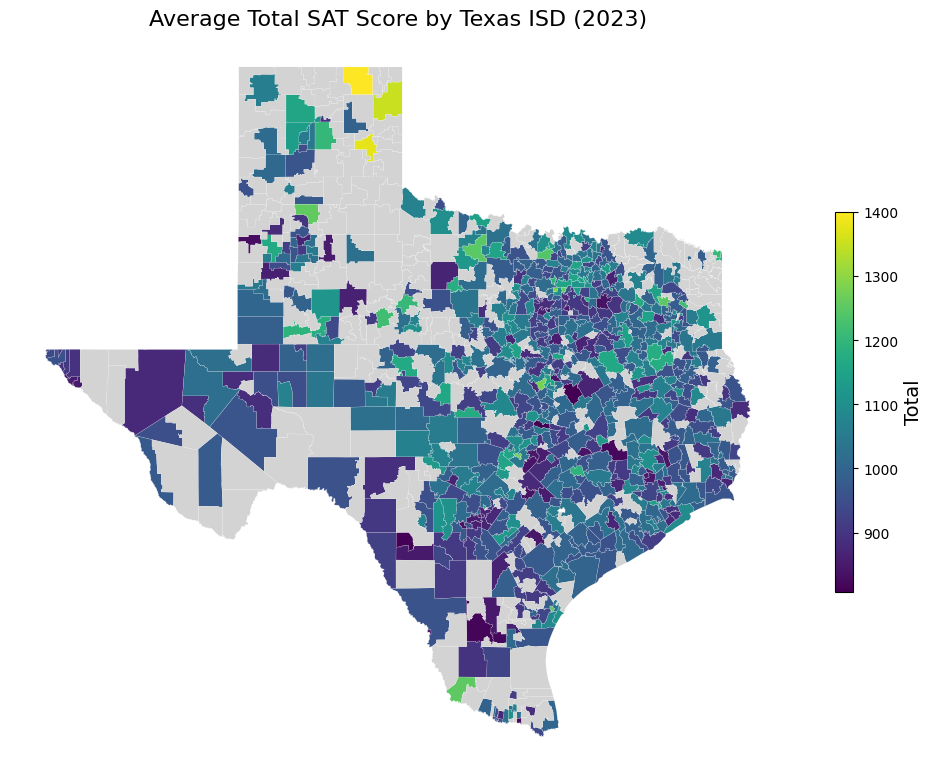

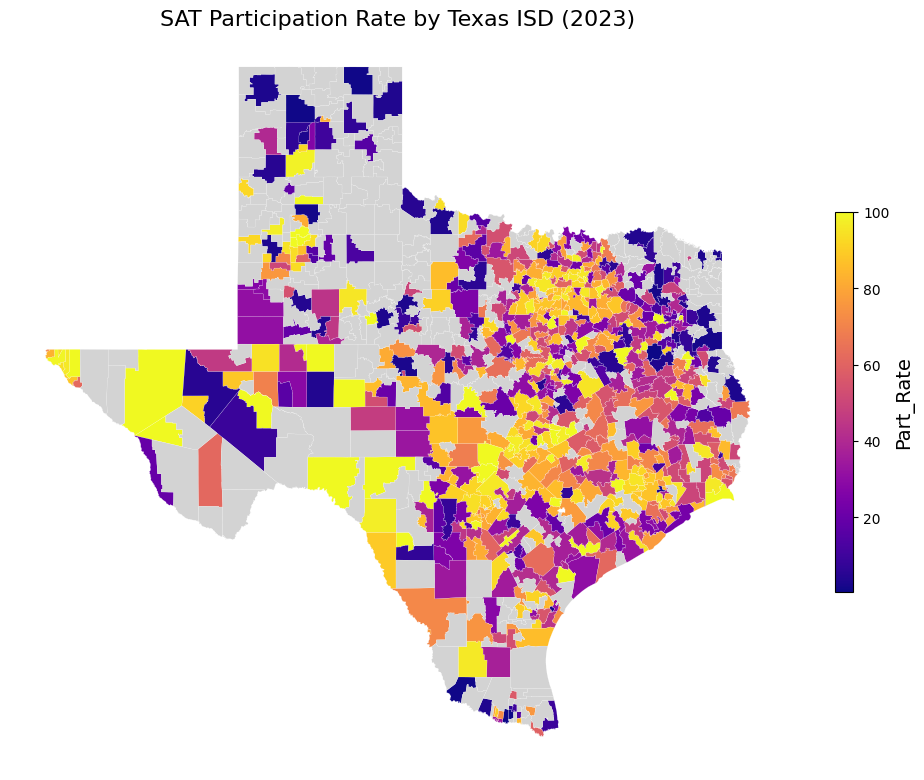

In [5]:
# ───────── Section 5: Map Total SAT & Participation ─────────

# 1. Join metrics to the GeoDataFrame
map_df = (
    isd_tx
      .set_index("JOIN_NAME")
      .join(metrics[["Total","Part_Rate","Above_TSI_Both_Rate"]], how="left")
)

# 2. Plot Total SAT
plot_choropleth(
    map_df,
    column="Total",
    cmap="viridis",
    title="Average Total SAT Score by Texas ISD (2023)"
)

# 3. Plot Participation Rate
plot_choropleth(
    map_df,
    column="Part_Rate",
    cmap="plasma",
    title="SAT Participation Rate by Texas ISD (2023)"
)


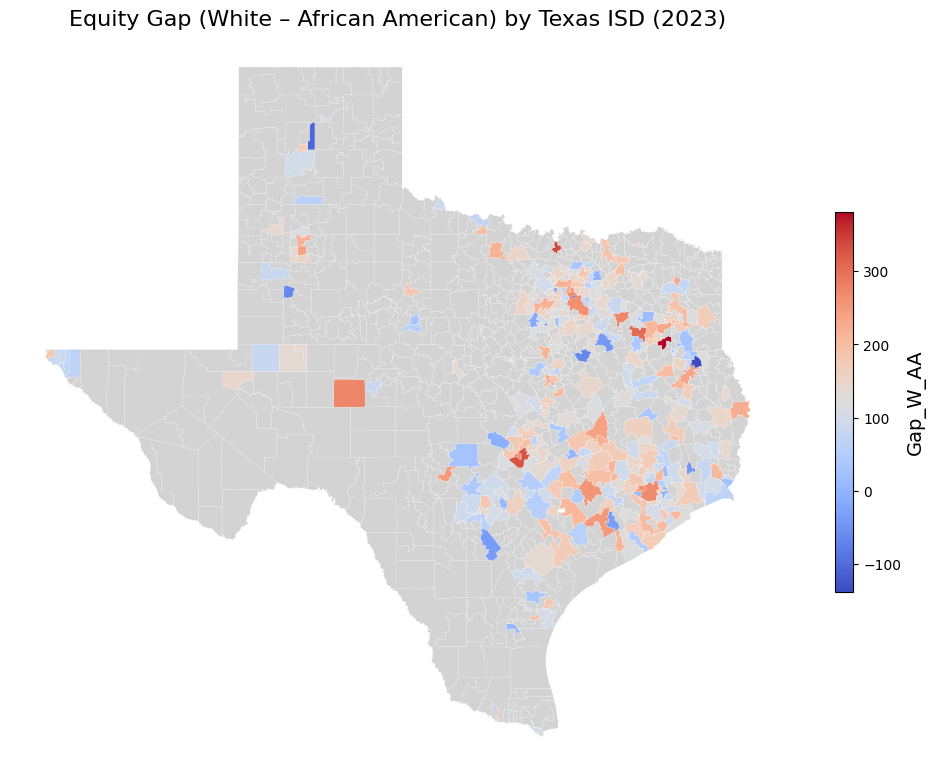

In [6]:
# ───────── Section 6 : Compute & Map Equity Gap ─────────

import pandas as pd
import geopandas as gpd

# 1. Load & clean the raw SAT data
raw = pd.read_excel(SAT_PATH, sheet_name="sat-district-data-class-2023")

# 2. Clean the 'Total' column in place (<25, <50 → NaN → float)
raw["Total"] = raw["Total"].replace(r"<\d+", pd.NA, regex=True).astype(float)

# 3. Pivot to wide format so each group is its own column
gap = (
    raw
    .pivot_table(index="DistName", columns="Group", values="Total")
    .dropna(subset=["White", "African American"])  # keep only where both exist
)

# 4. Compute the equity gap
gap["Gap_W_AA"] = gap["White"] - gap["African American"]

# 5. Join that gap back to the GeoDataFrame
map_gap = (
    isd_tx
    .set_index("JOIN_NAME")
    .join(gap[["Gap_W_AA"]], how="left")
)

# 6. Plot the choropleth
plot_choropleth(
    map_gap,
    column="Gap_W_AA",
    cmap="coolwarm",
    title="Equity Gap (White – African American) by Texas ISD (2023)"
)


Intercept: -165.20054662986772
Coefficients: {'Total': 0.19941144310218234, 'Part_Rate': -0.006484111347094678}
R²: 0.838, MAE: 5.532, RMSE: 8.508


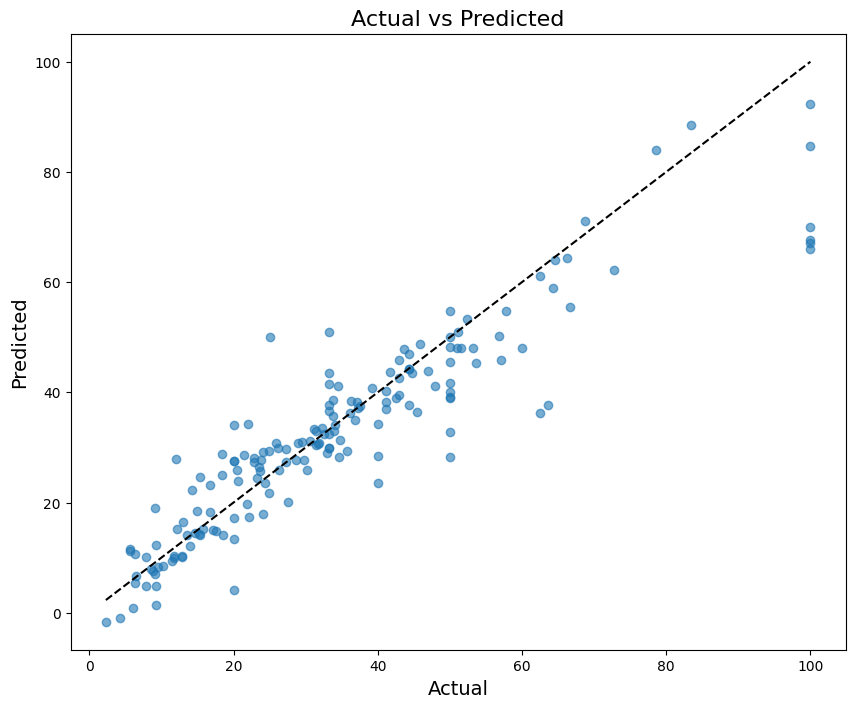

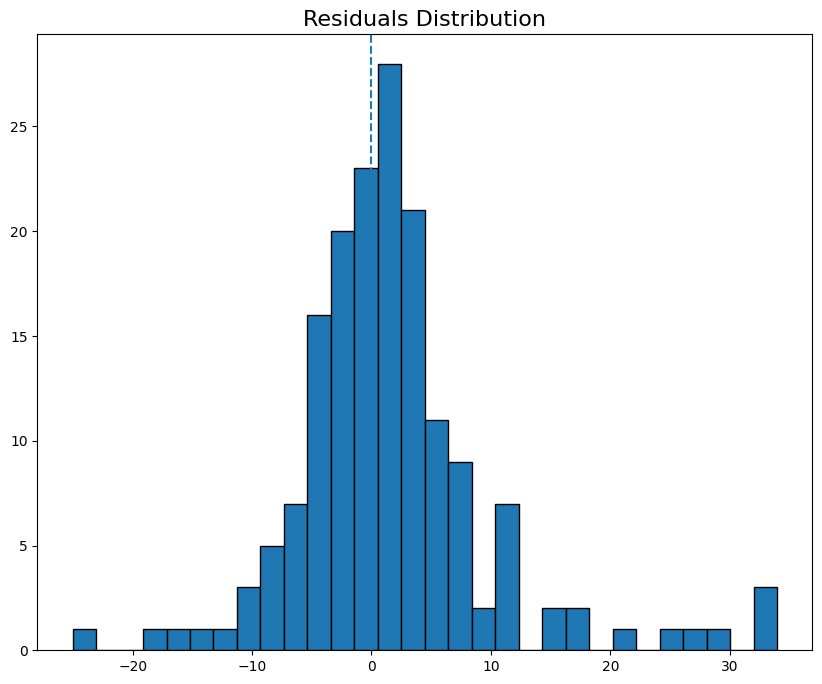

In [7]:
# ───────── Section 7: Regression Modeling & Diagnostics ─────────

# Prepare data
X = metrics[["Total","Part_Rate"]]
y = metrics["Above_TSI_Both_Rate"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit
model = LinearRegression().fit(X_train, y_train)
print("Intercept:", model.intercept_)
print("Coefficients:", dict(zip(X.columns, model.coef_)))

# Diagnostics
y_pred = model.predict(X_test)
print(f"R²: {r2_score(y_test,y_pred):.3f}, MAE: {mean_absolute_error(y_test,y_pred):.3f}, RMSE: {np.sqrt(mean_squared_error(y_test,y_pred)):.3f}")

# Residual plot
res = y_test - y_pred
plt.scatter(y_test, y_pred, alpha=0.6); plt.plot([y.min(),y.max()],[y.min(),y.max()],"k--")
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("Actual vs Predicted"); plt.show()

plt.hist(res, bins=30, edgecolor="k"); plt.axvline(0,ls="--"); plt.title("Residuals Distribution"); plt.show()


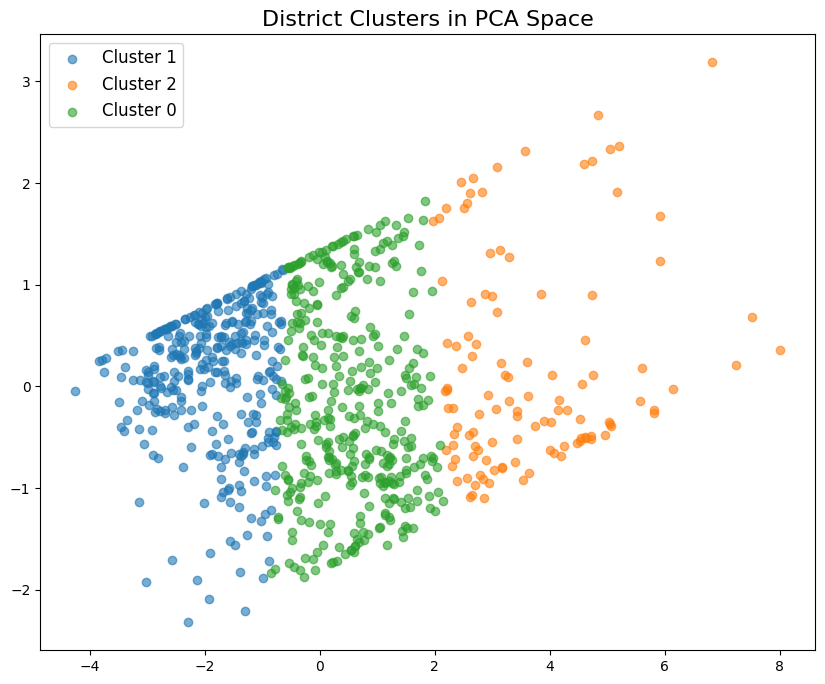

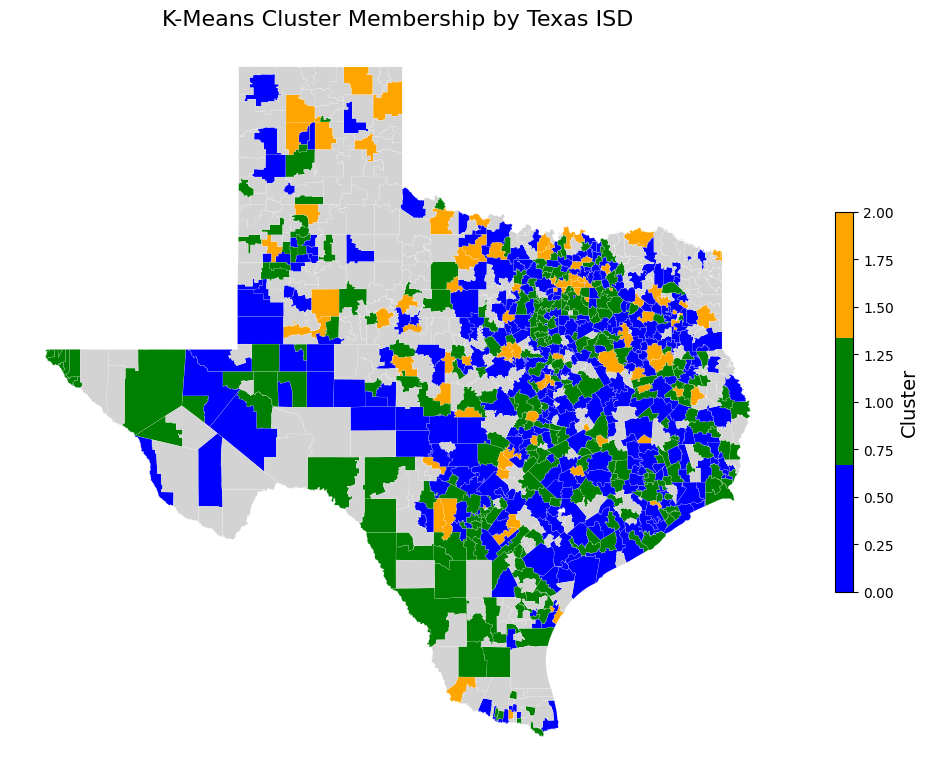

In [8]:
# ───────── Section 8: PCA & K-Means Clustering ─────────
from matplotlib.colors import ListedColormap

# 1. Scale & PCA
scaled = StandardScaler().fit_transform(metrics)
pc = PCA(2, random_state=42).fit_transform(scaled)
pca_df = pd.DataFrame(pc, columns=["PC1","PC2"], index=metrics.index)

# 2. K-Means
kmeans = KMeans(n_clusters=3, random_state=42).fit(pca_df)
pca_df["Cluster"] = kmeans.labels_

# 3. Plot clusters
fig, ax = plt.subplots()
for c in pca_df.Cluster.unique():
    subset = pca_df[pca_df.Cluster==c]
    ax.scatter(subset.PC1, subset.PC2, label=f"Cluster {c}", alpha=0.6)
ax.set_title("District Clusters in PCA Space"); ax.legend(); plt.show()

# 4. Map clusters
map_c = isd_tx.set_index("JOIN_NAME").join(pca_df[["Cluster"]], how="left")
rgb_cmap = ListedColormap(['blue', 'green', 'orange'])
plot_choropleth(
    map_c, 
    column="Cluster", 
    cmap=rgb_cmap, 
    title="K-Means Cluster Membership by Texas ISD"
)
